In [1]:
%matplotlib inline

import glob
import json
import os

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from utils.analysis import compute_mean_free_energy_traj
from utils.thermolength import (
    lower_bound_neighbor_acceptance_rates, upper_bound_neighbor_acceptance_rates,
    derivative_lower_bound_neighbor_acceptance_rates, derivative_upper_bound_neighbor_acceptance_rates
)
from analyze_hrex_calculations import read_free_energy_trajectory, experiment_name_to_info

In [2]:
# Constants.
YANK_DIR_PATH = os.path.join('..', 'yank')
FREE_ENERGY_TRAJ_DIR_PATH = os.path.join(YANK_DIR_PATH, 'free_energy_trajectories')
THERMO_LENGTH_DIR_PATH = os.path.join(YANK_DIR_PATH, 'thermo_length')
PLOTS_DIR_PATH = os.path.join(YANK_DIR_PATH, 'plots')

## Free energy bias and variance trade-offs

I selected 8 ligands (4 CB8 and 4 T4) and ran a few calculations to see the performance beyond CB8-G3 with the following protocols

- `trailblaze05` = trailblaze separating states at a thermodynamic length of 0.5 kT
- `trailblaze10` = trailblaze with 1kT separation
- `trailblaze20` = trailblaze with 2kT separation
- `manual10` = protocol with equally spaced lambdas (electrostatics is turned off at twice the speed of sterics) using a total number of states equal the average number of states found by trailblaze10.
- `manual20` = equally spaced lambdas, n_states = avg(trailblaze20)

The goal here is to show that:

- the variance using `trailblaze` is smaller than `manual` (with the same number of intermediate states)
- the variance is roughly the same for small thermo length spacing (i.e. 0.5kT and 1.0kT) but it decreases quickly if the protocol is too coarse (i.e. thermo length = 2.0kT)
- using the configurations generated by trailblaze to seed the replicates reduces the bias.

I thought I could initially run one long main calculation (10000 iterations) to estimate the converged free energy and variance, and two short replicates (5000 iterations) that I would need to estimate the initial bias.

In [30]:
def read_all_free_energy_trajectories():
    """Return all the free energy trajectories analyzed.

    Returns
    -------
    all_fe_trajectories : Dict[str, Dict[str, List[FreeEnergyTrajectory]]]
        all_fe_trajectories[system_name][protocol_name][replicate_idx] is
        the free energy trajectory data for the given system, protocol and
        replicate.

    """
    all_fe_trajectories = {}

    for fe_traj_file_base_path in glob.glob(os.path.join(FREE_ENERGY_TRAJ_DIR_PATH, '*.json')):
        file_base_path = os.path.splitext(fe_traj_file_base_path)[0]
        file_base_name = os.path.basename(file_base_path)

        # Isolate the replicate idx.
        system_protocol, _, replicate_idx = file_base_name.rpartition('-')
        replicate_idx = int(replicate_idx[len('replicate'):])

        # Isolate protocol name.
        system_name, _, protocol_name = system_protocol.rpartition('-')

        # Read free energy trajectory.
        fe_traj = read_free_energy_trajectory(file_base_path)

        # Update data.
        if system_name not in all_fe_trajectories:
            all_fe_trajectories[system_name] = {}
        if protocol_name not in all_fe_trajectories[system_name]:
            all_fe_trajectories[system_name][protocol_name] = []
        if len(all_fe_trajectories[system_name][protocol_name]) < replicate_idx+1:
            extension_len = replicate_idx + 1 - len(all_fe_trajectories[system_name][protocol_name])
            all_fe_trajectories[system_name][protocol_name].extend([None for _ in range(extension_len)])
        all_fe_trajectories[system_name][protocol_name][replicate_idx] = fe_traj

    return all_fe_trajectories


def plot_replicate_free_energy_trajectories(ax, free_energy_trajectories,
                                            plot_mean=True, plot_uncertainty=True,
                                            **plot_kwargs):
    """Plot the free energy trajectory replicates.

    Parameters
    ----------
    ax : matplotlib.Axes
        The Axes object over which to plot the trajectories.
    free_energy_trajectories : List[FreeEnergyTrajectory]
        free_energy_trajectories[i] is the free energy trajectory
        data for the i-th replicate.
    plot_mean : bool, optional, default True
        If True, the mean fre energy of the replicates is plotted
        instead of the single replicate trajectories.
    plot_uncertainty : bool, optional, default True
        If True, the uncertainty of the mean or of the single
        trajectories is plotted as well.
    """
    n_replicates = len(free_energy_trajectories)
    plot_kwargs = plot_kwargs.copy()
    label = plot_kwargs.pop('label', None)

    if plot_mean:
        # Find the trajectory with the largest number of energy evaluations.
        longest_replicate_idx = np.argmax([len(fe) for fe in free_energy_trajectories])
        energy_evals = free_energy_trajectories[longest_replicate_idx].energy_evals
        mean_traj, std_traj = compute_mean_free_energy_traj(
            [fe.f_traj for fe in free_energy_trajectories])

        ax.plot(energy_evals, mean_traj, label=label, **plot_kwargs)
        if plot_uncertainty:
            ci_traj = 2 * std_traj / np.sqrt(n_replicates)
            ax.fill_between(energy_evals, mean_traj - ci_traj, mean_traj + ci_traj, alpha=0.35, **plot_kwargs)
    else:
        # Plot single trajectories.
        for i, fe_traj in enumerate(free_energy_trajectories):
            # We add the label only to 1 replicate for the lengend.
            if i == 0:
                kw = {'label': label, **plot_kwargs}
            else:
                kw = plot_kwargs

            # Check if we need to print error bars as well.
            if plot_uncertainty:
                ax.errorbar(x=fe_traj.energy_evals, y=fe_traj.f_traj,
                            yerr=fe_traj.df_traj, alpha=0.5, **kw)
            else:
                ax.plot(fe_traj.energy_evals, fe_traj.f_traj, **kw)


def plot_free_trajectory_comparison(protocol_filters=None, output_file_name=None, **kwargs):
    """Plot all the free energy trajectories.

    Parameters
    ----------
    protocol_filters : Set[str], optional
        If given, only the trajectories whose protocol name matches at
        least one of the given filters are plotted.
    output_file_name : str, optional
        If given, the plot is saved in PLOTS_DIR_PATH under this name.
    plot_mean : bool, optional, default True
        If True, the mean fre energy of the replicates is plotted
        instead of the single replicate trajectories.
    plot_uncertainty : bool, optional, default True
        If True, the uncertainty of the mean or of the single
        trajectories is plotted as well.
    """
    from openmmtools.constants import kB
    from simtk import unit

    sns.set_context('notebook')
    sns.set_style('whitegrid')

    temperature = 298.15 * unit.kelvin
    kT = kB * temperature
    kT_to_kcalmol = kT / unit.kilocalories_per_mole

    # Load data.
    all_fe_trajectories = read_all_free_energy_trajectories()

    # One plot for each system.
    system_names = sorted(all_fe_trajectories.keys())
    n_cols = 4
    n_rows = int(np.ceil(len(system_names)/n_cols))
    fix, axes = plt.subplots(figsize=(12, 1 + 4*n_rows), ncols=n_cols, nrows=n_rows, sharey=True)

    for system_idx, system_name in enumerate(system_names):
        # Isolate the axes object for this system.
        ax_col = system_idx % n_cols
        ax_row = int(system_idx / n_cols)
        ax = axes[ax_row, ax_col]

        # Plot the free energy.
        system_fe_trajectories = all_fe_trajectories[system_name]
        for protocol_name in sorted(system_fe_trajectories.keys()):
            # Check if this protocol must be plotted.
            if protocol_filters is not None:
                for protocol_filter in protocol_filters:
                    if protocol_filter in protocol_name:
                        break
                else:
                    # No matches. Skip plotting this trajectory.
                    continue

            # If some replicates haven't been analyzed, we discard them.
            protocol_fe_trajectories = [fe for fe in system_fe_trajectories[protocol_name] if fe is not None]
            len_diff = len(protocol_fe_trajectories) - len(system_fe_trajectories[protocol_name])
            if len_diff != 0:
                print(f'Could not find {abs(len_diff)} replicates of {system_name}-{protocol_name}')
            plot_replicate_free_energy_trajectories(ax, protocol_fe_trajectories,
                                                    label=protocol_name, **kwargs)

        # Configure axes.
        # ax.set_xlim((0.0, n_energy_eval_interval*min_length))
        ax.set_ylim((-40, 2))

        ax.set_title(system_name)
        ax.set_ylabel('$\Delta$G [kcal/mol]')
        ax.set_xlabel('n energy/force evaluations')
        ax.legend()

    plt.tight_layout()
    if output_file_name is not None:
        os.makedirs(PLOTS_DIR_PATH, exist_ok=True)
        plt.savefig(os.path.join(PLOTS_DIR_PATH, output_file_name))
    else:
        plt.show()

### Bias-variance trade-off when re-seeding

Here is the comparison between `manual` and `trailblaze`. The `trailblaze` bias is much better than `manual` (as expected), but because `manual` replicates start always from the same initial conditions (while I use trailblaze to seed the replica in the other case), I think the variance is underestimated and we can’t show that thermodynamic length spacing is better in terms of variance. For a fair comparison, I’m now running CB8 `trailblaze` calculations without re-seeding the replicates so that they will start from the same configurations as `manual`.

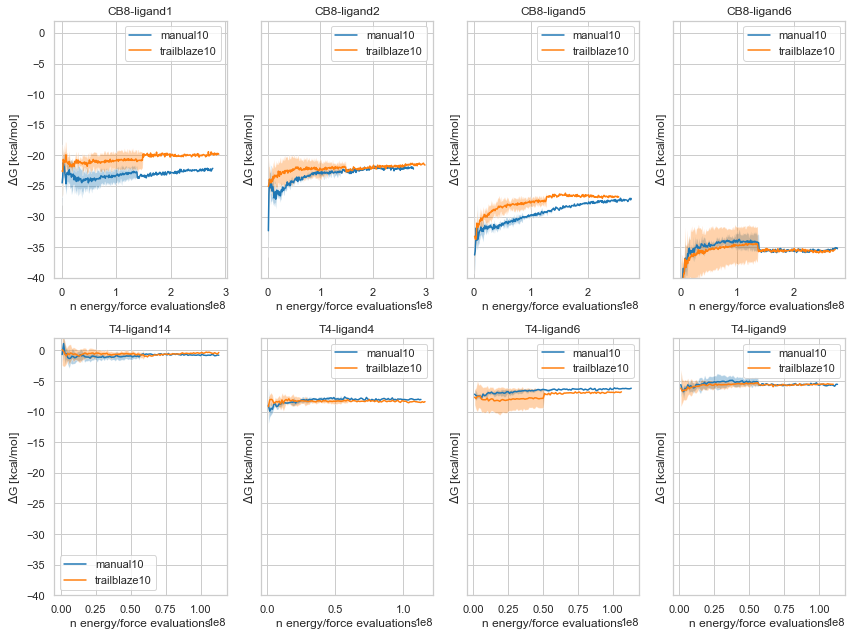

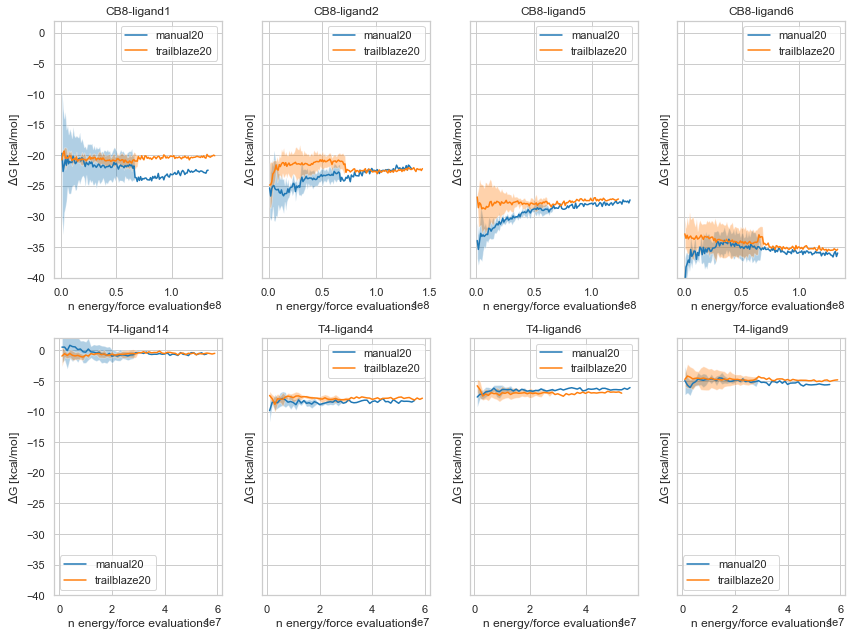

In [32]:
plot_free_trajectory_comparison(protocol_filters={'10'},
                                plot_mean=True, plot_uncertainty=True)
plot_free_trajectory_comparison(protocol_filters={'20'},
                                plot_mean=True, plot_uncertainty=True)

### The variance does not decreases when the thermodynamic spacing increases

Here is a comparison of the different trailblaze runs. Here the variance as a function of the “coarseness” is not at all as I expected. I believe the main responsible is again the seeding of the replicates so the “unseeded” runs should prove my point better, but this is a sign that the number of replicates is too small for a robust estimate so I’m running another couple of replicates. Alternatively, it is possible that threshold 2.0kT is still to small to observe significant changes in variance and maybe I should push it to 3kT.

Could not find 1 replicates of CB8-ligand1-trailblaze05
Could not find 1 replicates of T4-ligand14-trailblaze05
Could not find 1 replicates of T4-ligand4-trailblaze05
Could not find 1 replicates of T4-ligand9-trailblaze05


/Users/andrea/miniconda/envs/bleedingedge/lib/python3.6/site-packages/numpy/ma/core.py:4212: RuntimeWarning: invalid value encountered in multiply
  getdata(other)))


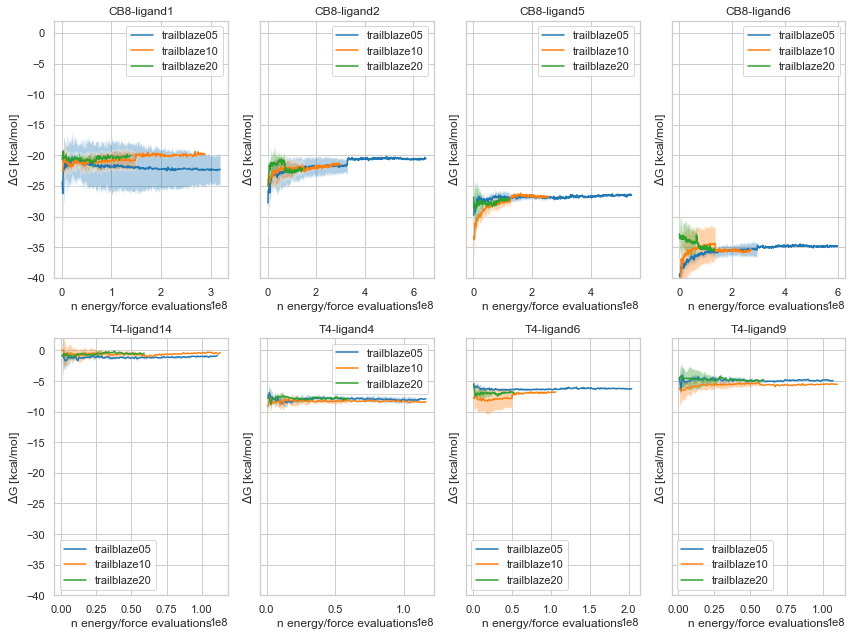

In [31]:
plot_free_trajectory_comparison(protocol_filters={'trailblaze'},
                                plot_mean=True, plot_uncertainty=True)

## Thermodynamic length analysis

The goal here is to verify the following:

1. The standard deviation of the instantaneous work provides a good and simple estimator of the thermodynamic length based.
2. Thermodynamic trailblazing ends up separating the states equally in thermodynamic length even if the initial simulation is very short.
3. Thermodynamic trailblazing, contrarily to equal lambda-spacing protocols results in roughly constant acceptance rates between states.
4. The theoretical boundaries on acceptance rates predicted by Shenfeld and Xu are empirically satisfied even if we're not in the limit of an infinite number of intermediate states.

### Thermodynamic trailblazing allows robust control of the neighbor acceptance rates

First, let's check how the lower and upper bounds of the neighbor acceptance rate vary with the thermodynamic distance between the two states.

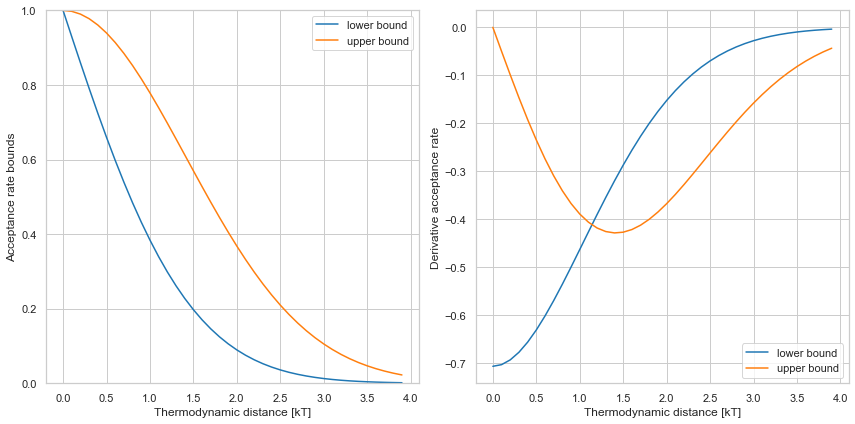

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
x = np.arange(0.0, 4.0, 0.1)

ax = axes[0]
ax.plot(x, lower_bound_neighbor_acceptance_rates(x), label='lower bound')
ax.plot(x, upper_bound_neighbor_acceptance_rates(x), label='upper bound')
ax.set_ylabel('Acceptance rate bounds')
ax.set_ylim((0, 1))

ax = axes[1]
ax.plot(x, derivative_lower_bound_neighbor_acceptance_rates(x), label='lower bound')
ax.plot(x, derivative_upper_bound_neighbor_acceptance_rates(x), label='upper bound')
ax.set_ylabel('Derivative acceptance rate')

for ax in axes:
    ax.set_xlabel('Thermodynamic distance [kT]')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
def experiment_path_to_info(experiment_dir_path):
    """Shortcut function to make experiment_name_to_info work with full paths."""
    experiment_name = os.path.splitext(os.path.basename(experiment_dir_path))[0]
    return experiment_name_to_info(experiment_name)


def plot_acceptance_rates():
    sns.set_context('notebook')
    sns.set_style('whitegrid')

    # Collect all the analyzed experiments and systems.
    all_experiments_data_file_paths = list(glob.glob(os.path.join(THERMO_LENGTH_DIR_PATH, '*.json')))
    system_names = set(experiment_path_to_info(path)[0] for path in all_experiments_data_file_paths)
    protocol_types = set(experiment_path_to_info(path)[3] for path in all_experiments_data_file_paths)

    # One row for each receptor-ligand system, one col for trailblaze and manual protocols.
    n_rows = len(system_names)
    n_cols = len(protocol_types)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8*n_cols, 6*n_rows))
    system_name_to_row_idx = {name: i for i, name in enumerate(sorted(system_names))}
    protocol_type_to_col_idx = {name: i for i, name in enumerate(sorted(protocol_types))}

    # We bars and bounds using pair colors.
    palette = sns.color_palette('Paired')
    thermo_length_to_color = {0.5: 0, 1.0: 1, 2.0: 2}
    
    # Keep track of the maximum number of states in each axes,
    # which we'll use later to make the ticks less crowded.
    max_n_states = np.zeros(shape=axes.shape, dtype=np.int)

    # Plot all the data.
    for experiment_data_file_path in all_experiments_data_file_paths:
        # Get info for the experiment.
        info = experiment_path_to_info(experiment_data_file_path)
        system_name, _, _, protocol_type, thermo_length_threshold, _ = info

        # Find axes object to plot on.
        row_idx = system_name_to_row_idx[system_name]
        col_idx = protocol_type_to_col_idx[protocol_type]
        ax = axes[row_idx, col_idx]

        # Import the JSON data.
        with open(experiment_data_file_path, 'r') as f:
            experiment_data = json.load(f)

        # Determine colors.
        color_idx = thermo_length_to_color[thermo_length_threshold]
        bar_color = palette[2*color_idx]
        bound_color = palette[2*color_idx + 1]

        # Bar plot for acceptance rates.
        neighbor_acceptance_rates = experiment_data['complex']['acceptance']
        n_states = len(neighbor_acceptance_rates) + 1
        all_states = list(range(n_states-1))
        sns.barplot(all_states, neighbor_acceptance_rates, color=bar_color, ax=ax,
                    label=f'thermo distance = {thermo_length_threshold}kT',
                    zorder=thermo_length_threshold)
        
        # Update max number of states.
        max_n_states[row_idx, col_idx] = max(max_n_states[row_idx, col_idx], n_states)

        # Plot lower and upper bounds if this a protocol found through trailblazing.
        if protocol_type == 'trailblaze':
            l_bound = lower_bound_neighbor_acceptance_rates(thermo_length_threshold)
            u_bound = upper_bound_neighbor_acceptance_rates(thermo_length_threshold)
            ax.plot(all_states, [l_bound for _ in all_states], color=bound_color,
                    zorder=thermo_length_threshold*4)
            ax.plot(all_states, [u_bound for _ in all_states], color=bound_color,
                    zorder=thermo_length_threshold*4)

        # Configure axes.
        ax.set_title(f'{protocol_type} protocol - {system_name}')
        ax.set_ylabel('neighbor acceptance rate')
        ax.set_xlabel('state index')
        ax.set_ylim((0, 1))

        ax.legend()
    
    # Fix x-axis ticks.
    for n_states, ax in zip(max_n_states.flatten(), axes.flatten()):
        # Make the ticks less crowded.
        ticks = list(range(0, n_states, 3))
        tick_labels = [str(i) for i in ticks]

        # We set the ticks **between** states since bars represent acceptance rates between pairs.
        ticks = np.array(ticks) - 0.5
        ax.set_xticklabels(tick_labels)
        ax.set_xticks(ticks)

    plt.tight_layout()
#     plt.show()
    plt.savefig('acceptance_rates.pdf')

This is a plot of the acceptance rates between neighbor states obtained by HREX for the different protocols. On the left, the simulation using the manual, equally-spaced lambda windows, and on the right the trailblaze protocol. The manual protocols used for a receptor have a number of intermediate states equal to the average number of states found by the trailblaze algorithm. The horizontal lines represent the theoretical bounds (from Shenfeld 2009) on the neighbor acceptance rate for the thermodynamic length threshold that was used during thermodynamic trailblazing.

The acceptance rates are always within theoretical predictions even if we don't have a continuous range of states. Also the manual protocol, with equally spaced lambda windows vary a lot across states and between systems.

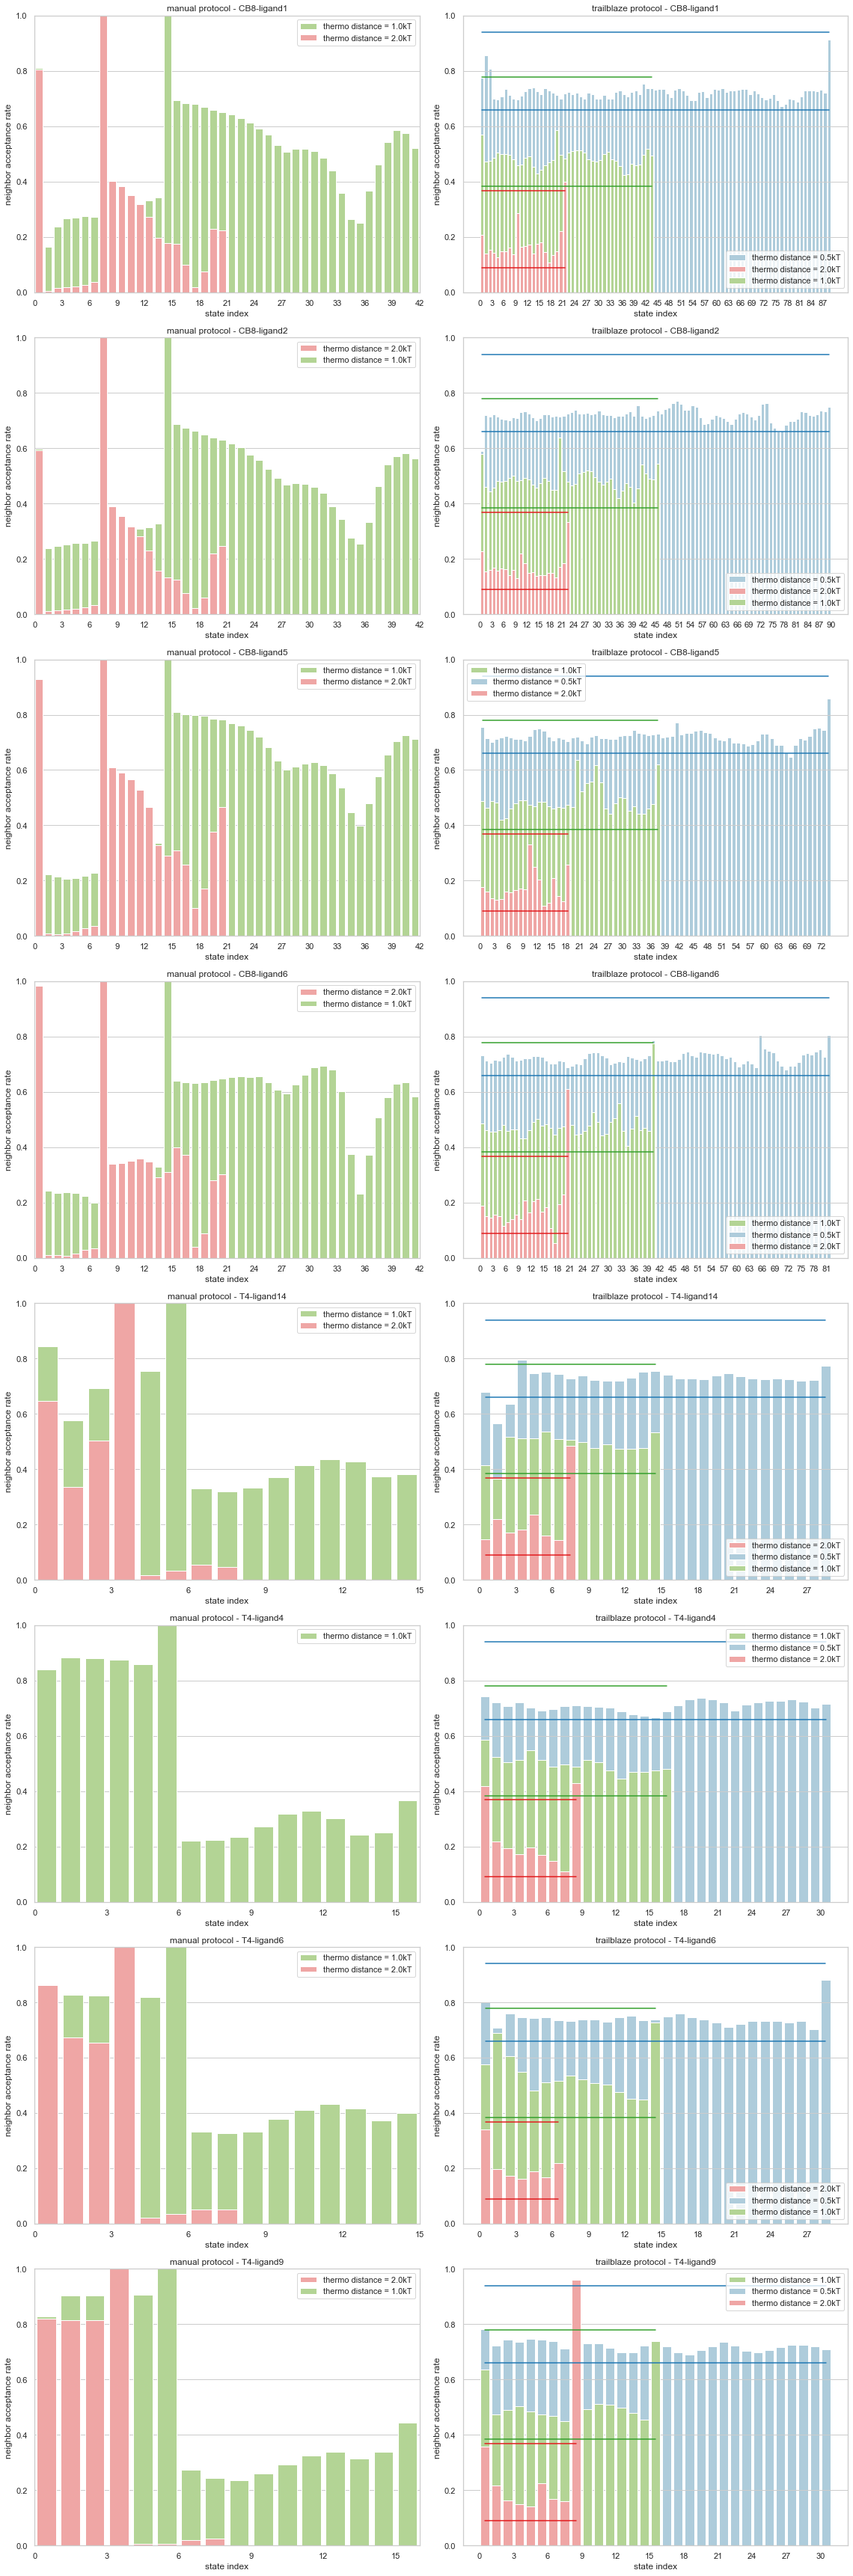

In [17]:
plot_acceptance_rates()